## 🧪 1.1: Functions

#### Setup

In [267]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt


#get_ipython().magic('matplotlib inline')
sns.set(
    context="notebook",
    style="whitegrid",
    palette="rocket_r",
    font_scale=1,
    color_codes=True,
    rc=None,
)
# sns.set_theme(context='notebook', style='whitegrid', palette='rocket_r', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set(rc={'figure.figsize':(8,6)})

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Inter']


#### Experiment Environment

In [268]:
# Global Parameters

def getExperimentEnvironment():
    env = {};
    env["num"] = 10000  # Number of points for the density function
    env["num_repl"] = 1000  # Number of repetitions to get the frequency and statistics of the distribution of Z
    env["nq"] = 21  # Number of questions
    env["tau"] = 20  # Response time threshold

    # Four performance profiles, each with a mean accuracy (theta) and mean response time (lambda)
    env["real_params"] = [
        (0.9, 1),  # Fast and accurate (Fluent/Mastered)
        (0.9, 0.1),  # Slow and accurate (Struggling Fluent)
        (0.5, 0.5),  # Average speed and accuracy (average)
        (0.1, 0.1)  # Slow and inaccurate (wheel-spinning)
    ]
    env['profile_names'] = ['Fluent', 'Struggling Fluent', 'Average', 'Wheel-spinning']

    # Pessimistic prior: Assuming the student is slow and inaccurate
    env["a"] = 1
    env["b"] = 1
    env["n"] = 2
    env["g"] = 11

    # Optimistic prior: Assuming the student is fast and accurate
    env["a2"] = 1.95
    env["b2"] = 0.05
    env["n2"] = 2
    env["g2"] = 7

    # Range of continuous parameter values for theta (mean accuracy) and lambda (mean response time)
    env["num_t"] = 100
    env["num_l"] = 100

    return env


#### 1. 🧪 True Distribution()
     - The distribution of Z is a joint product of two indepedent Random Variables: 
     1. Accuracy (E[Α] ~ θ) and 
     2. Response time (E[T] ~ λ)
      - The mass of Z is concentrated towards either 0 or 1 due to the linear penalization of response time (1 - rt/τ).
      - The standard deviation is fixed based on the true values of θ and λ.

In [269]:
# the score distribution given the real or the updated state
def true_distribution(theta, lamda, tau, num):
    env = getExperimentEnvironment();
    #accuracy is modelled as a binomial random variable
    accuracy = np.random.binomial(n=1, p=theta, size=num)
    #response time is modelled as an exponential random variable
    rt = np.random.exponential(scale=1/lamda, size=num)
    # z is the score distribution
    z = accuracy * (1 - np.minimum(rt, tau) / tau) #responsible for making the function range [0,1]

    return z


#### 2. 🧪 Estimate Distribution
  - This section implements a Bayesian mechanism with conjugate priors to estimate the unknown parameters of the true distribution (E[λ] ~ n/g).
  - The density of Z, the score variable, is highly dependent on the prior parameters.
  - This function can be used for sensitivity analysis to understand how sensitive the prior is to the true distribution.
  - The standard deviation of the estimated distribution depends on several factors, including the priors, the true lambda and theta values, the sequence of alpha, beta, and gamma, and the number of questions (n).


In [270]:
def est_distribution(par_a, par_b, par_n, par_g, tau, num):
    # priors
    theta = np.random.beta(a = par_a, b = par_b)
    lamda = np.random.gamma(shape = par_n, scale = 1/par_g)
    z = true_distribution(theta, lamda, tau, num)

    return z


#### 3. 🧪 Kullback-Leibler Divergence 
  - Also known as relative entropy D(pk|qk)]
  - Measures the information gain achieved by using the posterior distribution p instead of the prior distribution q
  - It quantifies the difference between two probability distributions p and q
  - The Kullback-Leibler Divergence is calculated as the sum of p[i] * log(p[i]/q[i]) across all values of i in the density points
  - Each density point represents the averaged data instances of individual performances given a specific (θ,λ) combination


In [271]:
# Define the function to calculate and return the KLD between p and q
# 🆘 Ensure that there are no zero probability values
# Replace any zero values in p and q with 0.001 to avoid infinity values in the logarithm calculation
    # p,q = np.where(p!=0, p, 0.001), np.where(q!=0, q, 0.001)To avoid division by zero, we replace any zero values in p and q with a small value (0.001)
def calculate_kl(p, q):
    kl_p_q = np.sum(p * np.log(p / q))
    return kl_p_q


##### A way to decide the threshold for the KLD rule
    - 2 students, 1 is good and 1 is bad, calculate the max distance between them, and use the max distance as a threshold
    ❗️the order that you put bad and good matters

Kullback-Leibler Divergence (KLD) between bad and good students (Direction 1): 2.1502989841351594
Kullback-Leibler Divergence (KLD) between good and bad students (Direction 2): 18.092224538585576


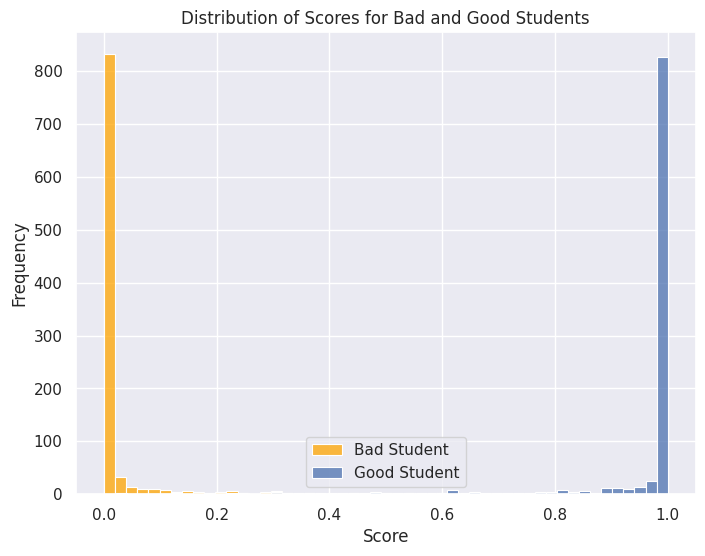

In [272]:

# Generate random scores for a bad student using a beta distribution
bad = np.random.beta(a=0.05, b=0.95, size=1000)
# Generate random scores for a good student using a beta distribution
good = np.random.beta(a=0.95, b=0.05, size=1000)


# Calculate the Kullback-Leibler Divergence (KLD) between the distributions of the bad and good students
ent = stats.entropy(bad, good, base=None, axis=0)

# Calculate the KLD between the distributions of the bad and good students in both directions
thresKLD1 = stats.entropy(bad, good, base=None, axis=0)
thresKLD2 = stats.entropy(good, bad, base=None, axis=0)

# Print the calculated KLD values
print("Kullback-Leibler Divergence (KLD) between bad and good students (Direction 1):", thresKLD1)
print("Kullback-Leibler Divergence (KLD) between good and bad students (Direction 2):", thresKLD2)

# Create a figure
fig = plt.figure(figsize=(8, 6))

# Plot the distributions of the bad and good students
sns.histplot(bad, bins = 50, label='Bad Student', color='orange')
sns.histplot(good, bins = 50, label='Good Student')

# Set the labels and title of the plot
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores for Bad and Good Students')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


#### 4. 🧪 1 Session of performance experience: 
            Fit the posterior parameters according to θ, λ params
            Monte Carlo Simulation: evaluate the mean of Z score over 1 sequence of nq length for 1 prior
            

In [273]:
# @TODO Vectorize
def a_session(theta, lamda, tau, par_a, par_b, par_n, par_g, nq):
    # parameter for the binomial distribution
    result_theta = np.zeros(nq)
    # parameter for the exponential distribution
    result_lamda = np.zeros(nq)
    #parameters for the beta distribution
    result_a = np.zeros(nq)
    result_b = np.zeros(nq)
    #parameters for the gamma distribution
    result_n = np.zeros(nq)
    result_g = np.zeros(nq)

    # the first question update the parameters
    result_theta[0] += par_a / (par_a + par_b)
    result_lamda[0] += par_n / par_g

    result_a[0] += par_a
    result_b[0] += par_b
    result_n[0] += par_n
    result_g[0] += par_g

    for i in range(nq-1):
        # simulate the response time and the accuracy
        correct = np.random.binomial(n=1, p = theta)
        rt = np.random.exponential(scale = 1/lamda)
        # update the parameters according to the response time and the accuracy
        par_a += correct
        par_b += (1 - correct)
        par_n += 1
        par_g += rt
        # update the theta and the lamda
        result_theta[i+1] += par_a / (par_a + par_b)
        result_lamda[i+1] += par_n / par_g

        result_a[i+1] += par_a
        result_b[i+1] += par_b
        result_n[i+1] += par_n
        result_g[i+1] += par_g

    return result_theta, result_lamda, result_a, result_b, result_n, result_g


### 4.1. 🧪 Realizations
  - Replicate the estimated distribution to get replicates of its sample stas(μ, σ, etc)
  - Score Z: Each response (i) for each MC sample (repl), there is a density function associated with the Random Variable of Z.

In [274]:
# @TODO Vectorize
def get_realizations(real_theta, real_lambda, tau, num, par_a, par_b, par_n, par_g, nq, num_repl):
    score = np.zeros((num_repl,nq,num))
    # 1 simulation of an assessment session
    for repl in range(num_repl):
        est_theta, est_lamda, est_a, est_b, est_n, est_g = a_session(
            real_theta,
            real_lambda,
            tau,
            par_a,
            par_b,
            par_n,
            par_g,
            nq
        )
        # for each respose in each sample, there is an asociated distribution
        # these are the values of the distribution and not the density
        for i in range(nq):
            score[repl, i,:] = est_distribution(
                est_a[i],
                est_b[i],
                est_n[i],
                est_g[i],
                tau,
                num
            )

    return score


## 🤖 1.2: Simulated Experience

>🚨🚨🚨Rerunning this code will update the specified file with new data.
> Make sure you save in the correct file!!!🚨🚨🚨

In [275]:
# # @TODO Vectorize
# env = getExperimentEnvironment();

# # prior03 = (env["a"], env["b"], env["n"], env["g"])
# # prior07 = (env["a2"], env["b2"], env["n2"], env["g2"])

# # priors = np.array([prior03, prior07])

# scores = np.zeros((
#     2,
#     len(env["real_params"]),
#     env["num_repl"],
#     env["nq"],
#     env["num"]
# ))

# # np.arrange(env["real_params"]).

# for j in range(len(env["real_params"])):
#     real_theta = env["real_params"][j][0]
#     real_lambda = env["real_params"][j][1]

#     scores[0][j] = get_realizations(
#         real_theta,
#         real_lambda,
#         env["tau"],
#         env["num"],
#         env["a"],
#         env["b"],
#         env["n"],
#         env["g"],
#         env["nq"],
#         env["num_repl"]
#     )

#     scores[1][j] = get_realizations(
#         real_theta,
#         real_lambda,
#         env["tau"],
#         env["num"],
#         env["a2"],
#         env["b2"],
#         env["n2"],
#         env["g2"],
#         env["nq"],
#         env["num_repl"]
#     )

# # @TRY to Vectorize
# # prior03 = (env["a"], env["b"], env["n"], env["g"])
# # prior07 = (env["a2"], env["b2"], env["n2"], env["g2"])
# # scores03 = np.array(len(env["real_params"]))
# # scores03

# Store the simulations for later usage
# createFile("./stats", scores)


In [276]:
# Re- running this will change the true scores file
#  env = getExperimentEnvironment()
# rpt = 100
# #shape: (4, 10000)
# true_scores = np.zeros((
#         len(env["real_params"]),
#         env["num"]
#         ))
# for i in range(rpt):
#     for j in range(len(env["real_params"])):
#         real_theta = env["real_params"][j][0]
#         real_lambda = env["real_params"][j][1]
#         true_scores[j] += true_distribution(real_theta,real_lambda,env["tau"], env["num"])
# true_scores /= rpt

# Store the true distributions for later usage
# createFile("./true_scores", true_scores)


## 2. 📊 Results - Visualizations

### 💾 Load Experiments from File

In [278]:
# true Z scores for the 4 performance profiles
true_scores = np.load("./repos/experimental_paper/csv_files/true_scores.npy")
# estimated Z for the 4 performance profiles
scores = np.load("./repos/experimental_paper/csv_files/stats.npy")
# estimated Z for the 4 performance profiles with the pessimistic prior
scores03 = scores[0]
# estimated Z for the 4 performance profiles with the optimistic prior
scores07 = scores[1]


### True parameters of the distribution for the 4 profiles 

In [279]:
### Calculate the true mean and std of the distribution for a student profile: students_true_scores[j] = (true_mean,true_std)
env = getExperimentEnvironment()

students_true_scores = [[] for j in range(len(env["real_params"]))]

for j in range(len(env["real_params"])):
    true_score  = true_scores[j]
    true_mean = true_score.mean()
    true_std = true_score.std()
    students_true_scores[j] = (true_mean,true_std)


print('True Mean and STD for each profile:')
for i in range(len(students_true_scores)):
    profile_name = env['profile_names'][i]
    true_mean, true_std = students_true_scores[i]
    print(f'{profile_name}: Mean={true_mean:.3f}, STD={true_std:.3f}')

#print('True (Mean and STD): \n\n' + str(np.round(students_true_scores,3)))


True Mean and STD for each profile:
Fluent: Mean=0.855, STD=0.029
Struggling Fluent: Mean=0.511, STD=0.036
Average: Mean=0.449, STD=0.045
Wheel-spinning: Mean=0.057, STD=0.020


### Calculate Statistics per prior: 
- Save the average statistics per prior in the `students_mean_stats` variable. The statistics include the mean, standard deviation (STD), standard error (SE), distribution, mean of the distribution, and STD of the distribution.
- The SE represents the precision of the estimated mean after calling the `sample_stats` function.
- The STD (standard deviation) is fixed and depends on the real parameters.
- The standard deviation across the mean of the distribution (`meanDist`) is always 0.01 for all students.
- We take the mean of each replication and then average over the replications because the results are fully random.


In [280]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Initialize an array to store the mean statistics for each student profile with the pessimistic prior
students_mean_stats03 = [[] for j in range(len(env["real_params"]))]

# Iterate over each student profile
for j in range(len(env["real_params"])):
    # Get the Z scores for the current student profile with the pessimistic prior
    score = scores03[j]

    # Calculate the average distribution of Z scores over all replications and items
    dist3 = score.mean(axis=0)

    # Calculate the sample mean and sample standard deviation arrays for each item
    meanDist3 = score.mean(axis=2)
    stdDist3 = score.std(axis=2)

    # Calculate the mean of the sample mean, mean of the sample standard deviation, and standard error of the sample mean
    mean_of_mean = meanDist3.mean(axis=0)
    mean_of_std = stdDist3.mean(axis=0)
    sem = np.divide(meanDist3.std(axis=0), np.sqrt(env["num_repl"]))

    # Save the mean statistics for the current student profile with the pessimistic prior
    students_mean_stats03[j] = (mean_of_mean, mean_of_std, sem, dist3, meanDist3, stdDist3)

# Repeat the same process for the optimistic prior
students_mean_stats07 = [[] for j in range(len(env["real_params"]))]

# Iterate over each student profile
for j in range(len(env["real_params"])):
    # Get the Z scores for the current student profile with the optimistic prior
    score = scores07[j]

    # Calculate the average distribution of Z scores over all replications and items
    dist7 = score.mean(axis=0)

    # Calculate the sample mean and sample standard deviation arrays for each item
    meanDist7 = score.mean(axis=2)
    stdDist7 = score.std(axis=2)

    # Calculate the mean of the sample mean, mean of the sample standard deviation, and standard error of the sample mean
    mean_of_mean = meanDist7.mean(axis=0)
    mean_of_std = stdDist7.mean(axis=0)
    sem = np.divide(meanDist7.std(axis=0), np.sqrt(env["num_repl"]))

    # Save the mean statistics for the current student profile with the optimistic prior
    students_mean_stats07[j] = (mean_of_mean, mean_of_std, sem, dist7, meanDist7, stdDist7)


In [281]:
# Smoothed final values taken from the mean of the distribution in .R file
# In the Python file, there was an error in the calculation of KLD as it returned infinite values at times.
# In the .R file, the KLD is calculated based on the mean of the distribution and it works fine.

# The values below are the smoothed values of the KLD for the 4 performance profiles:

# Average speed and accuracy profile for the pessimistic (03) and the optimistic prior (07)
avg03 = [21.2220250, 18.3738018, 15.6957386, 13.2679250, 11.0900674, 9.1713447, 7.4674573, 5.9709654, 4.6836773, 3.6011889, 2.6957128, 1.9786637, 1.4505364, 1.0958319, 0.8906404, 0.8019283, 0.7911040, 0.8291107, 0.8865476, 0.9396650]
avg07 = [4.160422e+01, 3.600661e+01, 3.053892e+01, 2.536844e+01, 2.063588e+01, 1.638440e+01, 1.269261e+01, 9.608856e+00, 7.104932e+00, 5.075968e+00, 3.455602e+00, 2.214443e+00, 1.306747e+00, 6.860853e-01, 2.990589e-01, 8.854634e-02, 9.071440e-06, -1.245524e-02, 1.251031e-02, 4.437195e-02]

# Fast and accurate profile for the pessimistic (03) and the optimistic prior (07)
mast03 = [37.921298, 36.283281, 34.555762, 32.566046, 30.131808, 27.166488, 23.721388, 19.999681, 16.352342, 12.872297, 9.929927, 7.636333, 5.954802, 4.707361, 3.681452, 2.952405, 2.544231, 2.377841, 2.280720, 2.107026]
mast07 = [56.051068, 48.450549, 40.582961, 32.557144, 25.075451, 18.647063, 13.427664, 9.681440, 7.207320, 5.737904, 4.787345, 3.955834, 3.367148, 3.115110, 3.111101, 3.095335, 2.789561, 2.342675, 1.904998, 1.517877]

# Fast and inaccurate profile for the pessimistic (03) and the optimistic prior (07)
acc07 = [49.700419, 42.199630, 34.775467, 27.663352, 21.324275, 15.862037, 11.567617, 8.298668, 5.903876, 4.241456, 3.084566, 2.226226, 1.673337, 1.393931, 1.301271, 1.332743, 1.436303, 1.517707, 1.514057, 1.433889]
acc03 = [35.9860740, 28.9469344, 22.1096688, 15.9921669, 11.1667678, 7.6307704, 5.3199147, 3.9266768, 3.1900586, 2.7493574, 2.2956789, 1.8015609, 1.3330439, 0.9705334, 0.7338261, 0.5848670, 0.4790474, 0.4148845, 0.3868175, 0.3808687]

# Slow and inaccurate profile for the pessimistic (03) and the optimistic prior (07)
wheel07 = [44.744530, 41.502645, 38.316687, 35.185675, 32.081530, 28.987224, 25.912099, 22.881985, 19.926345, 17.084681, 14.392730, 11.963410, 9.842071, 8.013151, 6.498158, 5.314931, 4.419621, 3.723617, 3.125296, 2.530492]
wheel03 = [41.253451, 37.466131, 33.639955, 29.762343, 25.873171, 22.013233, 18.297716, 14.916807, 11.937714, 9.401854, 7.314942, 5.614421, 4.271412, 3.243568, 2.517578, 2.077561, 1.892416, 1.913236, 2.088333, 2.350717]

# Store the KLD values of the 4 performance profiles for each prior separately
kl03 = [mast03, acc03, avg03, wheel03]
kl07 = [mast07, acc07, avg07, wheel07]


## 📊 Visualizations

## 🛑 Stopping Metric 1️⃣: Derivative of the Z Mean
#### The absolute difference between consecutive estimated mean values of the posterior distributions for the two priors.

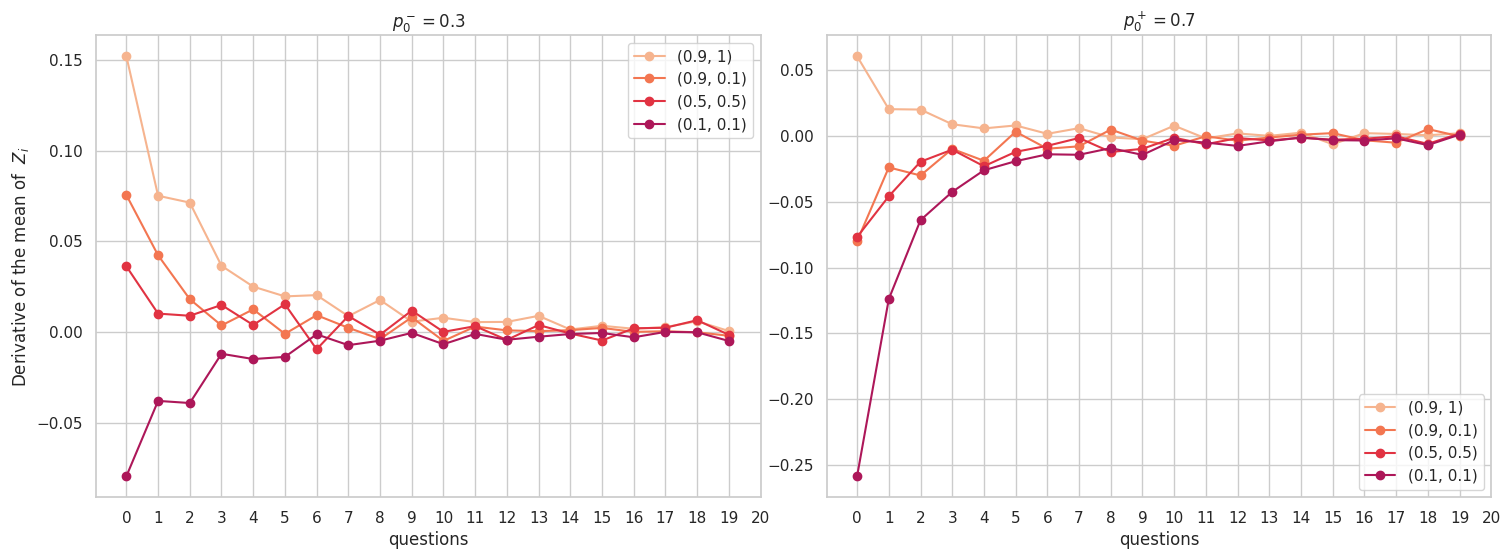

In [282]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Initialize empty lists to store the derivative of the mean values for each student profile and each prior
deriv_of_mean03 = [np.zeros(env["nq"]-1) for j in range(len(env["real_params"]))]
deriv_of_mean07 = [np.zeros(env["nq"]-1) for j in range(len(env["real_params"]))]
# Create a figure with two subplots
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(wspace=0.1)

# Set the color palette and context for the plots
sns.set_palette('rocket_r')
sns.set_context('notebook')

# Define the x-axis values
x = list(np.arange(3, 22))

# Create the first subplot
with sns.axes_style("whitegrid"):
    ax1 = fig.add_subplot(121)

    # Create the second subplot
    ax2 = fig.add_subplot(122)

    # Iterate over each student profile
    for j in range(len(env["real_params"])):
        # Left panel
        # Get the mean values of the Z scores for the current student profile with the pessimistic prior
        means_students03 = students_mean_stats03[j][0]

        # Calculate the derivative of the mean values for each question using the gradient function
        deriv_of_mean03[j] = [(np.gradient(np.array([t,s]))[0]) for t,s in zip(means_students03, means_students03[1:])]

        # Plot the derivative of the mean values for the current student profile with the pessimistic prior
        ax1.plot(deriv_of_mean03[j], marker='o', label = env["real_params"][j])

        ax1.legend()
        ax1.set_title(r'$p_0^- = 0.3$')
        ax1.set_ylabel('Derivative of the mean of 'r' $Z_i$')
        ax1.set_xlabel('questions')
        ax1.xaxis.set_ticks(np.arange(0,env["nq"],1))

        # Right panel
        # Get the mean values of the Z scores for the current student profile with the optimistic prior
        means_students07 = students_mean_stats07[j][0]

        # Calculate the derivative of the mean values for each question using the gradient function
        deriv_of_mean07[j] = [(np.gradient(np.array([t,s]))[0]) for t,s in zip(means_students07, means_students07[1:])]

        # Plot the derivative of the mean values for the current student profile with the optimistic prior
        ax2.plot(deriv_of_mean07[j], marker='o', label = env["real_params"][j])
        ax2.legend()
        ax2.set_title(r'$p_0^+ = 0.7$')
        ax2.set_xlabel('questions')
        ax2.xaxis.set_ticks(np.arange(0,env["nq"],1))


## 🛑 Stopping Metric 2️⃣: Kullback-Leibler divergence 
#### 1. The difference between consecutive estimated KL divergences for the two priors.

- The Kullback-Leibler (KL) divergence measures the difference between two probability distributions.
- If two distributions perfectly match, the KL divergence is 0. Otherwise, it can take values between 0 and ∞. 
- The y-axis shows the average frequency of the KL-Z scores values.
- The lower the KL divergence value, the better the match between the true distribution and our approximation.
- The plot shows two sets of red points, one on the left and one on the right, representing the KL divergence values for the two priors.


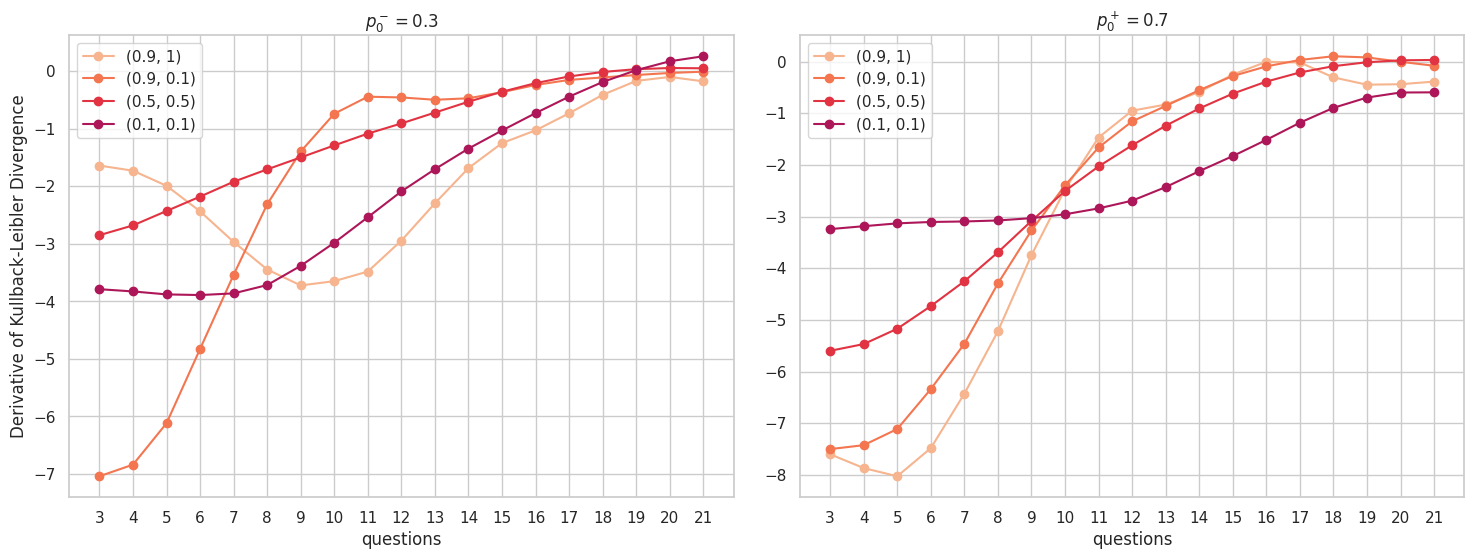

In [283]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(wspace=0.1)

# Set the color palette and context for the plots
sns.set_palette('rocket_r')
sns.set_context('notebook')

# Define the x-axis values
x = list(np.arange(3, 22))

# Create the first subplot
with sns.axes_style("whitegrid"):
    ax1 = fig.add_subplot(121)

    # Create the second subplot
    ax2 = fig.add_subplot(122)

    # Iterate over each performance profile
    for j in range(len(kl07)):
        # Plot the derivative of the Kullback-Leibler divergence for the pessimistic prior
        ax1.plot(x, (np.diff(np.asarray(kl03[j]))), marker='o', label=str(env['real_params'][j]))
        ax1.legend()
        ax1.set_title(r'$p_0^- = 0.3$')
        ax1.set_xlabel('questions')
        ax1.set_ylabel('Derivative of Kullback-Leibler Divergence')
        ax1.xaxis.set_ticks(np.arange(3, env['nq'] + 1, 1))

        # Plot the derivative of the Kullback-Leibler divergence for the optimistic prior
        ax2.plot(x, (np.diff(np.asarray(kl07[j]))), marker='o', label=str(env['real_params'][j]))
        ax2.legend()
        ax2.set_title(r'$p_0^+ = 0.7$')
        ax2.set_xlabel('questions')
        ax2.xaxis.set_ticks(np.arange(3, env['nq'] + 1, 1))


### The same as the above code but with plotting the absolute differences now

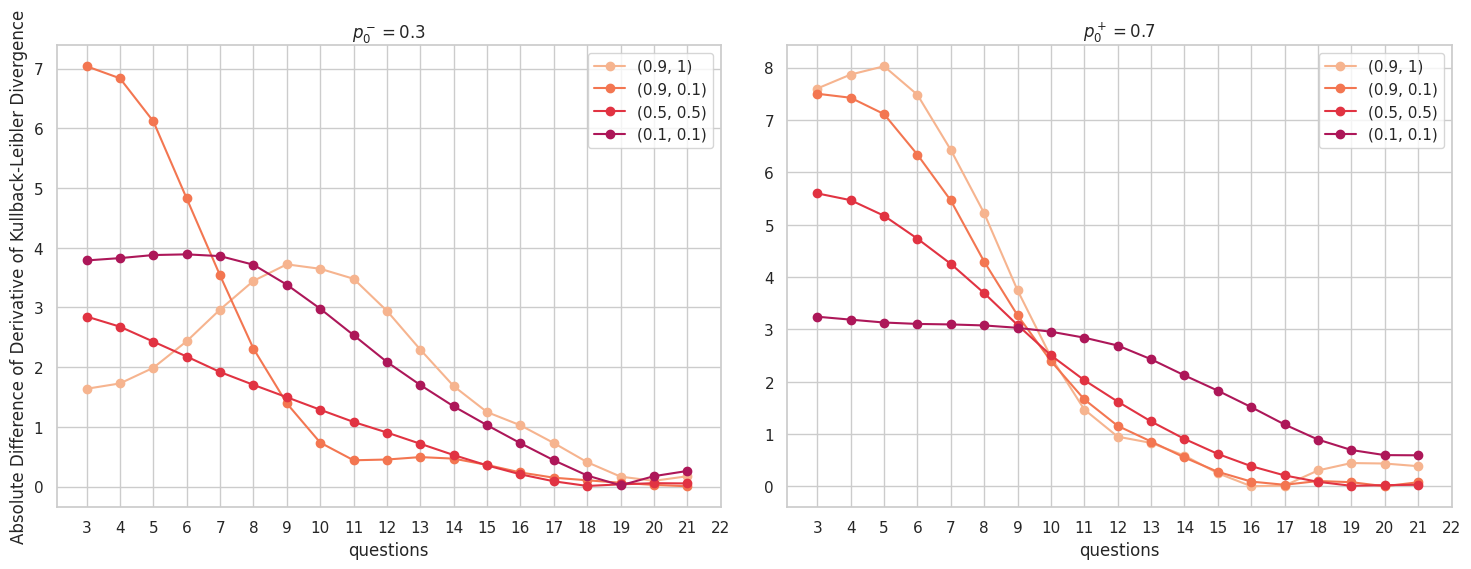

In [284]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(wspace=0.1)

# Set the color palette and context for the plots
sns.set_palette('rocket_r')
sns.set_context('notebook')

# Define the x-axis values
x = list(np.arange(3, 22))

# Create the first subplot
with sns.axes_style("whitegrid"):
    ax1 = fig.add_subplot(121)

    # Create the second subplot
    ax2 = fig.add_subplot(122)

    # Iterate over each performance profile
    for j in range(len(kl07)):
        # Plot the absolute difference of the derivative of the Kullback-Leibler divergence for the pessimistic prior
        ax1.plot(x, np.abs(np.diff(np.asarray(kl03[j]))), marker='o', label=str(env['real_params'][j]))
        ax1.legend()
        ax1.set_title(r'$p_0^- = 0.3$')
        ax1.set_xlabel('questions')
        ax1.set_ylabel('Absolute Difference of Derivative of Kullback-Leibler Divergence')
        ax1.xaxis.set_ticks(np.arange(3, env['nq'] + 2, 1))

        # Plot the absolute difference of the derivative of the Kullback-Leibler divergence for the optimistic prior
        ax2.plot(x, np.abs(np.diff(np.asarray(kl07[j]))), marker='o', label=str(env['real_params'][j]))
        ax2.legend()
        ax2.set_title(r'$p_0^+ = 0.7$')
        ax2.set_xlabel('questions')
        ax2.xaxis.set_ticks(np.arange(3, env['nq'] + 2, 1))


### Plot just the KLD values rather than the differences of KLD values

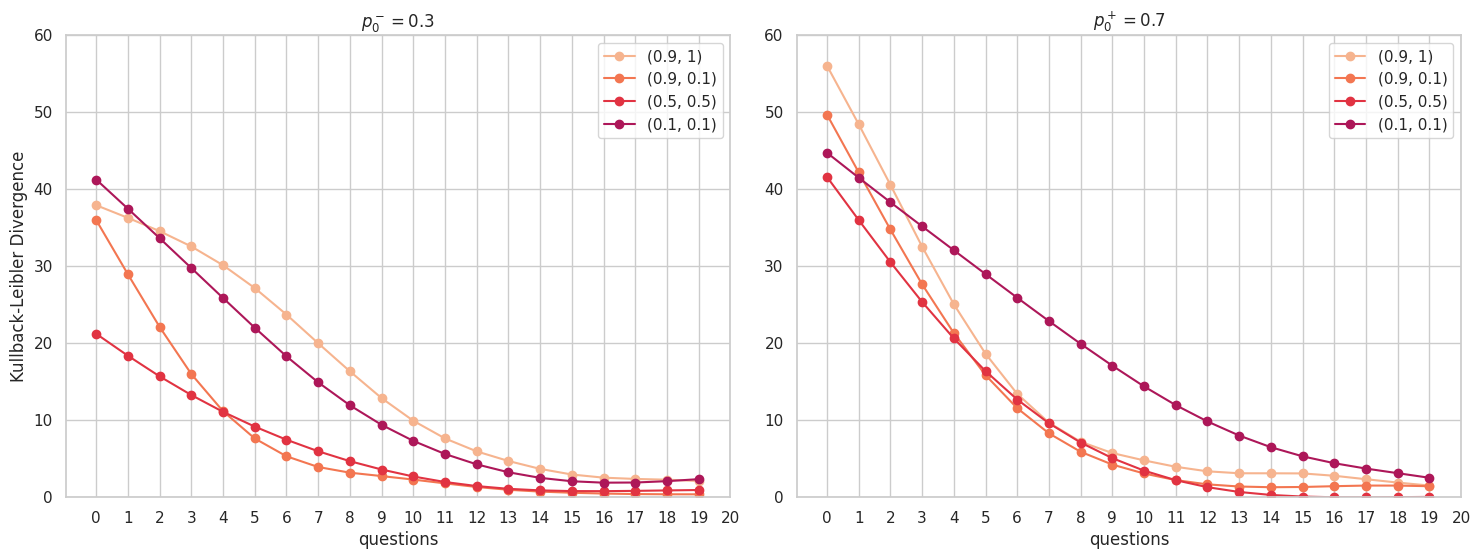

In [285]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(wspace=0.1)

# Set the color palette and context for the plots
sns.set_palette('rocket_r')
sns.set_context('notebook')

# Create the first subplot
with sns.axes_style("whitegrid"):
    ax1 = fig.add_subplot(121)

    # Create the second subplot
    ax2 = fig.add_subplot(122)

    # Iterate over each performance profile
    for j in range(len(kl07)):
        # Plot the Kullback-Leibler divergence for the pessimistic prior
        ax1.plot(kl03[j], marker='o', label=str(env['real_params'][j]))
        ax1.set_ylim(ymin=0, ymax=60)
        ax1.legend()
        ax1.set_title(r'$p_0^- = 0.3$')
        ax1.set_xlabel('questions')
        ax1.set_ylabel('Kullback-Leibler Divergence')
        ax1.xaxis.set_ticks(np.arange(0, env['nq'], 1))

        # Plot the Kullback-Leibler divergence for the optimistic prior
        ax2.plot(kl07[j], marker='o', label=str(env['real_params'][j]))
        ax2.set_ylim(ymin=0, ymax=60)
        ax2.legend()
        ax2.set_title(r'$p_0^+ = 0.7$')
        ax2.set_xlabel('questions')
        ax2.xaxis.set_ticks(np.arange(0, env['nq'], 1))


## Side-Functions 
  1. Performance Evaluation: Experimentally test the performance of the model by letting go of one assumption.
  2. Model Behavior Analysis: Explore the isocurves and understand how the parameters θ and λ affect the mean (μ) and standard deviation (σ) of Z.
  3. Sensitivity Analysis: Analyze the impact of the prior on the Z scores over the assessment session.


### Exponential Accuracy Increase
This section explores a model that incorporates exponential accuracy increase over time. The model considers the following factors:

In [286]:
# Function to generate theta values over time with exponential accuracy increase

# Parameters:
#   - initial_theta: The initial value of theta for the first item
#   - upper_bound: The upper bound for theta (1 in this case).As the number of items approaches infinity, theta will reach its upper bound.
#   - rate: The rate at which theta increases over time (smaller rate leads to slower increase)
#   - t: The time intervals or number of questions
# Returns:
#   - theta_t: The theta value at time t

def generate_theta(initial_theta, upper_bound, rate, t):
    theta_t = upper_bound - (upper_bound - initial_theta) * (rate ** t)
    return theta_t


In [287]:
# Re-simulate the assessment session with the new function for theta in the binomial distribution
def change_acc_session(par_a, par_b, initial_theta,upper_bound,rate,nq):
    est_theta = np.zeros(nq)
    result_a = np.zeros(nq)
    result_b = np.zeros(nq)
    true_theta =np.zeros(nq)

    for i in range(nq):

        if i==0:
            est_theta[i] +=   par_a / (par_a + par_b)
            result_a[i] += par_a
            result_b[i] += par_b

            true_theta[i] += initial_theta #equals to theta

        else:
            # simulate the response accuracy and take that as the score
            correct = np.random.binomial(n=1, p = generate_theta(initial_theta,upper_bound,rate,i))

            par_a += correct
            par_b += (1 - correct)
            est_theta[i] += par_a / (par_a + par_b)
            result_a[i] += par_a
            result_b[i] += par_b

            # true theta for each item
            true_theta[i] = generate_theta(initial_theta,upper_bound,rate,i)

    return est_theta,true_theta


In [288]:
# Take the average of the replicated theta values
# Take the mean of each replication and then average over the replications because the results are fully random.
def avg_session(par_a, par_b, initial_theta,upper_bound,rate,nq, num_repl):
    est_theta,theta_t = np.zeros(nq),np.zeros(nq)
    theta_t = change_acc_session(par_a, par_b, initial_theta,upper_bound,rate,nq)[1]

    for repl in range(num_repl):
        #so as to get the replicated param values
        result_theta = change_acc_session(par_a, par_b, initial_theta,upper_bound,rate,nq)[0]

        for i in range(nq):
            est_theta[i] += result_theta[i] #same to result_a[i]/(result_a[i]+result_b[i])
    est_theta /= num_repl#result_theta more conservative compare to new_theta but picks it up
    return(est_theta,theta_t)


### Convergence of the estimated accuracy parameter (yellow lines) to an evolving true parameter value (red lines).
The true value evolves according to an exponential rise model. The parameter r is listed above each graph and gives the
steepness of the rise, with lower values corresponding to faster rises. The first two graphs correspond to a ˆθ0 = 0.5 and the
last two to an initial_theta = 0.75 with α and β parameters for the prior of theta as plotted in the legend

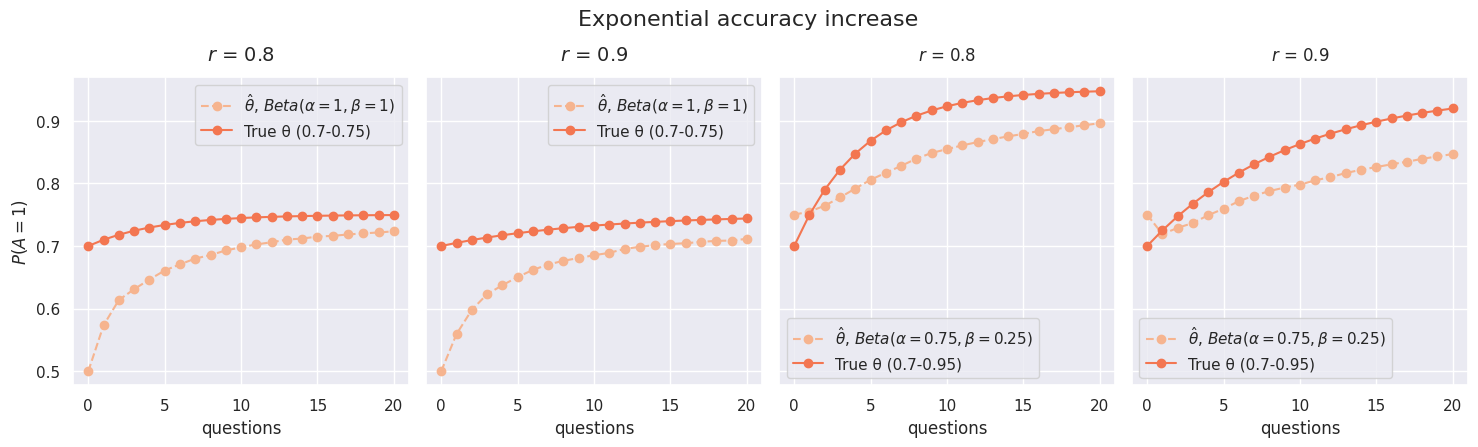

In [289]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Set the initial values for parameters par_a, par_b, initial_theta, and upper_bound
par_a, par_b, initial_theta, upper_bound = 1, 1, 0.7, 0.75

# Create a figure with four subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 4), sharey='row')
fig.subplots_adjust(wspace=0.05)

# Set the title for the figure
fig.suptitle('Exponential accuracy increase', fontsize=16, x=0.5, y=1.05)

# Define the rates for exponential accuracy increase
rates = [0.8, 0.9]

# Iterate over each rate
for r in range(len(rates)):
    # Calculate the average estimated theta values and true theta values using the avg_session function
    est_theta, theta_t = avg_session(par_a, par_b, initial_theta, upper_bound, rates[r], env["nq"], env["num_repl"])

    # Plot the estimated theta values and true theta values in the subplot
    axs[r].plot(est_theta, label=r'$\hat{\theta}$, $Beta(\alpha = 1, \beta = 1)$', marker='o', linestyle='dashed')
    axs[r].plot(theta_t, label='True θ (0.7-0.75)', marker='o')

    # Set the y-axis label for the first plot
    if r == 0:
        axs[r].set_ylabel(r'$P(A=1)$')

    # Set the x-axis label, legend, and title for each subplot
    axs[r].set_xlabel('questions')
    axs[r].legend()
    axs[r].set_title(r'$r$ = ' + str(rates[r]), fontsize=14, pad=12)

# Set different parameters for par_a, par_b, initial_theta, and upper_bound
par_a, par_b, initial_theta, upper_bound = 0.75, 0.25, 0.7, 0.95

# Iterate over each rate again
for r in range(len(rates)):
    # Calculate the average estimated theta values and true theta values using the avg_session function
    est_theta, theta_t = avg_session(par_a, par_b, initial_theta, upper_bound, rates[r], env["nq"], env["num_repl"])

    # Plot the estimated theta values and true theta values in the subplot
    axs[r + 2].plot(est_theta, label=r'$\hat{\theta}$, $Beta(\alpha = 0.75, \beta = 0.25)$', marker='o', linestyle='dashed')
    axs[r + 2].plot(theta_t, label='True θ (0.7-0.95)', marker='o')

    # Set the x-axis label, legend, and title for each subplot
    axs[r + 2].set_xlabel('questions')
    axs[r + 2].legend()
    axs[r + 2].set_title(r'$r$ = ' + str(rates[r]), pad=12)

# Display the figure
plt.show()


### 🕰️ Isocurves STD and Mean
      Based on the expecetd value of Z (i.e., E[Z], the empirical distribution, the algorithm came up with these boundaries for the parameters of response time and accuracy.
      (🆘 takes a while to run)

In [290]:
# ceil: Rounds up a decimal value to the nearest integer (e.g., 2.0 -> 2)
# 10 *: Divides a range of Z values (100 values) into 10 equal intervals (e.g., 10, 20, 30, etc.)
# 10 /: Converts a decimal value to a fraction (e.g., 0.1, 0.2, etc.)
# θ+1: A loop variable that starts from 0, so we add 1 to avoid a parameter value error

# Function to calculate the standard deviation of the true distribution for different theta and lambda values
def isocurves_std(num_t, num_l, num, tau):
    results = np.zeros((num_t, num_l), dtype=float)

    for theta in range(num_t):
        for lamda in range(num_l):
            results[theta, lamda] = np.ceil(10 * np.std(true_distribution((theta+1)/num_t, (lamda+1)/num_l, tau, num))) / 10
    return results


In [291]:
# Calculate the average standard deviation of the true distribution for different theta and lambda values
# by repeating the process multiple times (rpt times) and averaging the results

# Initialize an array to store the results
dataSTD = np.zeros((env["num_t"], env["num_l"]), dtype=float)

# Repeat the process rpt times
rpt = 10
for i in range(rpt):
    # Calculate the standard deviation of the true distribution for different theta and lambda values
    # using the isocurves_std function
    dataSTD += isocurves_std(
        env["num_t"],
        env["num_l"],
        env["num"],
        env["tau"]
    )

# Average the results by dividing by rpt
dataSTD /= rpt


In [292]:
# Do the same for the mean
def isocurves_mean(num_t, num_l, num, tau):
    results = np.zeros((num_t, num_l), dtype=float)

    for theta in range(num_t):
        for lamda in range(num_l):
            results[theta, lamda] = np.ceil(10 * np.mean(true_distribution((theta+1)/num_t, (lamda+1)/num_l, tau, num))) / 10
    return results


In [293]:
# Calculate the average mean of the true distribution for different theta and lambda values
# by repeating the process multiple times (rpt times) and averaging the results

# Initialize an array to store the results
dataMean = np.zeros((env["num_t"], env["num_l"]), dtype=float)

# Repeat the process rpt times
rpt = 10
for i in range(rpt):
    # Calculate the mean of the true distribution for different theta and lambda values
    # using the isocurves_mean function
    dataMean += isocurves_mean(
        env["num_t"],
        env["num_l"],
        env["num"],
        env["tau"]
    )

# Average the results by dividing by rpt
dataMean /= rpt


### The standard deviation of Z is highest for undetermined middle accuracy performance

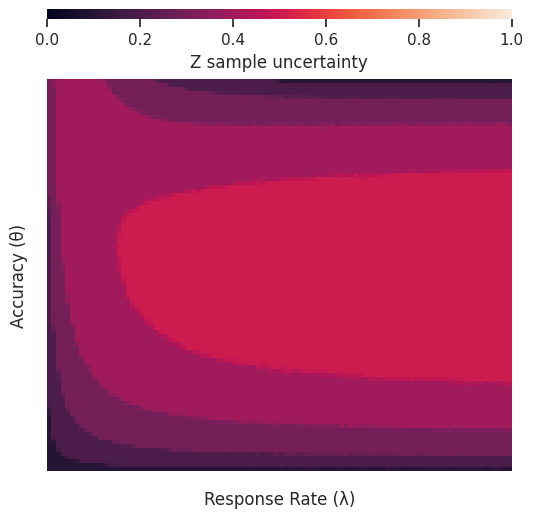

In [294]:
# Create a heatmap plot to visualize the uncertainty of Z scores
# The heatmap represents the standard deviation of the true distribution of Z scores
# The x-axis represents the response rate (λ) and the y-axis represents the accuracy (θ)
# The color of each cell in the heatmap indicates the level of uncertainty in the Z score
# The colorbar on top of the heatmap shows the range of Z sample uncertainty values

grid_kws = {"height_ratios": (0.05, 2), "hspace": 0.3}
fig, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(6,6))
yticks = np.linspace(0,1,10)
xticks = np.linspace(0,1,10)
ax = sns.heatmap(
    dataSTD,
    ax=ax,
    cbar_kws={"label": "Z sample uncertainty","orientation": "horizontal"},
    cbar_ax=cbar_ax,
    vmin = 0,
    vmax = 1,
    xticklabels=np.round(xticks,1),
    yticklabels=np.round(yticks,1))
ax.invert_yaxis()
ax.set_xlabel("Response Rate (λ)")
ax.set_ylabel("Accuracy (θ)")
ax.set_yticks(yticks*ax.get_ylim()[1])
ax.set_xticks(xticks*ax.get_xlim()[1])


### The expected value of Z increases with both higher accuracy and higher response rate in a nonlinear fashion

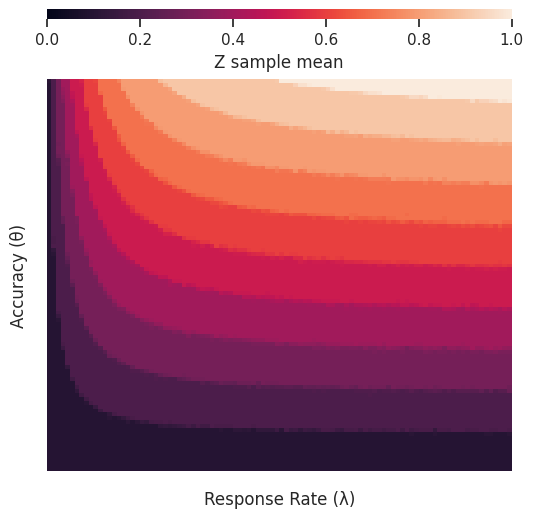

In [295]:
# Create a heatmap plot to visualize the mean of Z scores

grid_kws = {"height_ratios": (0.05, 2), "hspace": 0.3}
fig, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(6,6))

yticks = np.linspace(0,1,10)
xticks = np.linspace(0,1,10)
#r'\textbf{Z score}'
ax = sns.heatmap(
    dataMean,
    cbar_kws={'label': 'Z sample mean',"orientation": "horizontal"}, ax=ax, cbar_ax=cbar_ax, vmin = 0,vmax = 1, xticklabels=np.round(xticks,1), yticklabels=np.round(yticks,1))#xticklabels=[0.0]
ax.invert_yaxis()
ax.set_xlabel("Response Rate (λ)") #,fontsize=18
ax.set_ylabel("Accuracy (θ)")
ax.set_yticks(yticks*ax.get_ylim()[1])
ax.set_xticks(xticks*ax.get_xlim()[1])


#### Sensitivity Analysis
Comparison of the efficiency of convergence between the two different priors for all student profiles (these are depicted on top of each subgraph in the figure).

In [296]:
# Calculate (average) Z for 2 priors
# Prior 1(a,b,n,g), Prior 2(a2,b2,n2,g2), number of questions, number of replications
def sensitivity_analysis(real_theta, real_lambda, tau, num, a, b, n, g, a2, b2, n2, g2, nq, num_repl):
    result_z = np.zeros(nq)
    result_z2 = np.zeros(nq)

    for repl in range(num_repl):
        est_theta, est_lamda, est_a, est_b, est_n, est_g = a_session(real_theta, real_lambda, tau, a, b, n, g, nq)
        est_theta2, est_lamda2, est_a2, est_b2, est_n2, est_g2 = a_session(real_theta, real_lambda, tau, a2, b2, n2, g2, nq)
        for i in range(nq):
            result_z[i] += np.mean(est_distribution(est_a[i], est_b[i], est_n[i], est_g[i], tau, num))
            result_z2[i] += np.mean(est_distribution(est_a2[i], est_b2[i], est_n2[i], est_g2[i], tau, num))

    result_z /= num_repl
    result_z2 /= num_repl
    return(result_z,result_z2)


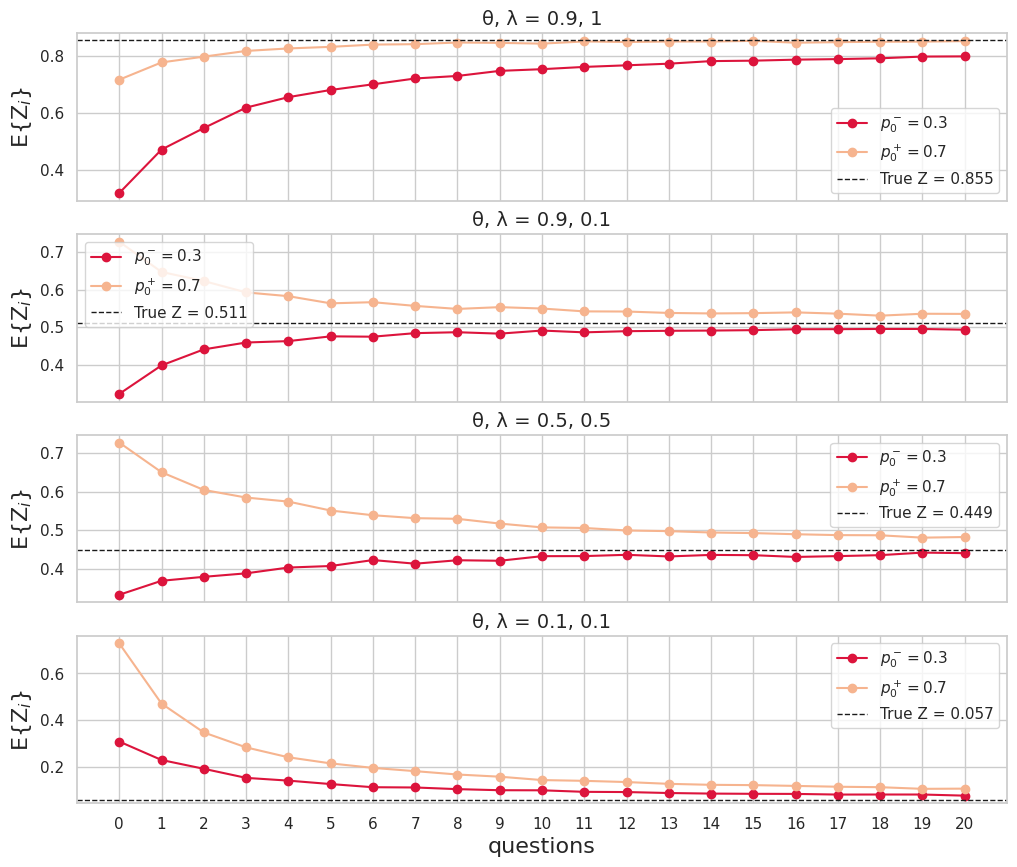

In [297]:
# Get the experiment environment settings
env = getExperimentEnvironment()

# Initialize an array to store the true mean scores
real_m = np.zeros(len(env["real_params"]))

# Set the color palette for the plots
sns.set_palette('rocket_r')

# Create a figure with subplots
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    # Iterate over each set of real parameters
    for j in range(len(env["real_params"])):
        # Get the real theta and lambda values
        real_theta = env["real_params"][j][0]
        real_lambda = env["real_params"][j][1]

        # Get the estimated mean scores for different priors
        result_z = students_mean_stats03[j][0]  # Pessimistic prior
        result_z2 = students_mean_stats07[j][0]  # Optimistic prior

        # Get the true mean score
        real_m[j] = np.round(students_true_scores[j][0], 3)

        # Get the corresponding subplot
        ax = axs[j]

        # Plot the estimated mean scores for different priors
        ax.plot(result_z, marker='o', color='crimson', label=r'$p_0^- = 0.3$')  # Pessimistic prior
        ax.plot(result_z2, marker='o', label=r'$p_0^+ = 0.7$')  # Optimistic prior

        # Plot the true mean score as a dashed line
        ax.axhline(
            real_m[j],
            color='k',
            linestyle='dashed',
            linewidth=1,
            label='True Z = ' + str(real_m[j])
        )

        # Set the title of the subplot
        ax.set_title('θ, λ = ' + str(real_theta) + (', ') + str(round(real_lambda, 3)), fontsize=14)

        # Set the x-axis ticks and labels
        ax.xaxis.set_ticks(np.arange(0, env["nq"], 1))
        ax.xaxis.set_label_text('questions', ha='center', fontsize=16)

        # Set the y-axis label
        ax.yaxis.set_label_text('E{Z' + r'$_i$' + '}', ha='center', fontsize=16)

        # Hide the outer labels for subplots except the bottom one
        ax.label_outer()

        # Add a legend to the subplot
        ax.legend()


1. The top line represents the mean of posterior distribution under the optimistic prior in the legend (orange) and the
bottom line (red) under the pessimistic prior. 
2.  The dashed black line depicts the true mean of the Z distribution. 
3. The estimated expected scores (dots) from item to item emphasize how the estimated score has changed relative to the score at the previous item.


# 🧁 Determining When to Stop the Assessment 🧁

In this section, we explore the criteria for determining when to stop the assessment process. We consider two different stopping rules based on the derivative of a metric, either the mean or the Kullback-Leibler Divergence (KLD).

## Stopping Rule 1️⃣: Mean Derivative

The first stopping rule is based on the derivative of the mean metric. If the difference between two consecutive points is smaller than a predefined threshold, denoted as epsilon, we stop the assessment. A higher epsilon value results in a more lenient stopping rule, leading to a shorter assessment sequence. However, for this rule, we require at least two responses before making a decision.

## Stopping Rule 2️⃣: KLD Derivative

The second stopping rule is based on the derivative of the Kullback-Leibler Divergence (KLD) metric. Similar to the mean derivative rule, we stop the assessment if the difference between two consecutive points is smaller than epsilon. However, for this rule, we require at least three responses before making a decision.

By considering these stopping rules, we can determine the optimal point to stop the assessment process, balancing the need for accuracy with efficiency.


In [298]:
# Returns the index of the item where two consecutive trials of the student performance are smaller than epsilon

def change_dev(metric,epsilon):
    #compute the differences between every pair of 2 consecutive elements
    diff =[abs(np.gradient(np.array([t,s]))[0]) for t,s in zip(metric, metric[1:])] # 0th item means i need 1 response
    #True if 2 consecutive differences are below epsilon
    cond = [np.logical_and(s<epsilon,t<epsilon) for s,t in zip(diff, diff[1:])] # 0th item means i need 2 responses
    # item where first True occurs
    item_index = [(i+2) for i, val in enumerate(cond) if val == True] #0=2 responses, 1=3 responses etc
    #print(item_index)
    return item_index


### Derivative of KLD, Posterior Mean 
    1. Prior 03 
    1.1 Strict
    1.2 Lenient
    
    2. Prior 07
    2.1 Strict
    2.2 Lenient



#### 1.1 Strict epsilon


In [299]:
# Initialize empty lists to store the stopping times for mean-based and KLD-based stopping rules
student_changes_mean_of_mean03 = [[] for j in range(len(env["real_params"]))]
student_changes_mean_of_dist03 = [[] for j in range(len(env["real_params"]))]

# Set the threshold values for the stopping rules
thresKLD1 = 1.08
thresmean1 = 0.01

print('Stopping time for the strict policies \n')

# Iterate over each set of real parameters
for j in range(len(env["real_params"])):
    # Calculate the stopping times based on the mean derivative stopping rule
    student_changes_mean_of_mean03[j] = change_dev(students_mean_stats03[j][0], 0.01)

    # Calculate the stopping times based on the KLD derivative stopping rule
    student_changes_mean_of_dist03[j] = change_dev(kl03[j], thresKLD1) # 0.0001, contains more information hence it needs a smaller threshold

    # Get the profile name for display
    profile_name = env["profile_names"][j]

    # Print the stopping times for the mean-based stopping rule
    print(f"Profile: {profile_name}")
    print(f"\nwith Mean & Threshold {thresmean1}:")
    print(student_changes_mean_of_mean03[j][:2])

    # Print the stopping times for the KLD-based stopping rule
    print(f"\nwith KL & Threshold {thresKLD1}:")
    print(student_changes_mean_of_dist03[j][:2])

    print("\n")


Stopping time for the strict policies 

Profile: Fluent

with Mean & Threshold 0.01:
[11, 12]

with KL & Threshold 1.08:
[15, 16]


Profile: Struggling Fluent

with Mean & Threshold 0.01:
[7, 8]

with KL & Threshold 1.08:
[9, 10]


Profile: Average

with Mean & Threshold 0.01:
[8, 9]

with KL & Threshold 1.08:
[11, 12]


Profile: Wheel-spinning

with Mean & Threshold 0.01:
[8, 9]

with KL & Threshold 1.08:
[14, 15]




#### 1.2 Lenient epsilon


In [300]:
# Initialize empty lists to store the stopping times for mean-based and KLD-based stopping rules
student_changes_mean_of_mean03_2 = [[] for j in range(len(env["real_params"]))]
student_changes_mean_of_dist03_2 = [[] for j in range(len(env["real_params"]))]

# Set the threshold values for the stopping rules
thresKLD2 = 2.16
thresmean2 = 0.02

print('Stopping time for the lenient policies \n' )

# Iterate over each set of real parameters
for j in range(len(env["real_params"])):
    # Calculate the stopping times based on the mean derivative stopping rule
    student_changes_mean_of_mean03_2[j] = change_dev(students_mean_stats03[j][0], thresmean2)

    # Calculate the stopping times based on the KLD derivative stopping rule
    student_changes_mean_of_dist03_2[j] = change_dev(kl03[j], thresKLD2)

    # Get the profile name for display
    profile_name = env["profile_names"][j]

    # Print the stopping times for the mean-based stopping rule
    print(f"Profile: {profile_name}")
    print(f"\nMean - Threshold {thresmean2}:")
    print(student_changes_mean_of_mean03_2[j][:2])

    # Print the stopping times for the KLD-based stopping rule
    print(f"\nKL - Threshold {thresKLD2}:")
    print(student_changes_mean_of_dist03_2[j][:2])

    print("\n")


Stopping time for the lenient policies 

Profile: Fluent

Mean - Threshold 0.02:
[9, 10]

KL - Threshold 2.16:
[2, 3]


Profile: Struggling Fluent

Mean - Threshold 0.02:
[4, 5]

KL - Threshold 2.16:
[8, 9]


Profile: Average

Mean - Threshold 0.02:
[3, 4]

KL - Threshold 2.16:
[6, 7]


Profile: Wheel-spinning

Mean - Threshold 0.02:
[5, 6]

KL - Threshold 2.16:
[11, 12]




#### 2.1 Prior 07 + Strict

In [301]:
# Hold change info per student
student_changes_mean_of_mean07 = [[] for j in range(len(env["real_params"]))]
student_changes_mean_of_dist07 = [[] for j in range(len(env["real_params"]))]

# Iterate over each set of real parameters
for j in range(len(env["real_params"])):
    # Calculate the stopping times based on the mean derivative stopping rule
    student_changes_mean_of_mean07[j] = change_dev(students_mean_stats07[j][0], thresmean1)

    # Calculate the stopping times based on the KLD derivative stopping rule
    student_changes_mean_of_dist07[j] = change_dev(kl07[j], thresKLD1)

    # Get the profile name for display
    profile_name = env["profile_names"][j]

    # Print the stopping times for the mean-based stopping rule
    print(f"Profile: {profile_name}")
    print(f"\nwith Mean & Threshold {thresmean1}:")
    print(student_changes_mean_of_mean07[j][:2])

    # Print the stopping times for the KLD-based stopping rule
    print(f"\nwith KL & Threshold {thresKLD1}:")
    print(student_changes_mean_of_dist07[j][:2])

    print("\n")


Profile: Fluent

with Mean & Threshold 0.01:
[5, 6]

with KL & Threshold 1.08:
[11, 12]


Profile: Struggling Fluent

with Mean & Threshold 0.01:
[7, 8]

with KL & Threshold 1.08:
[12, 13]


Profile: Average

with Mean & Threshold 0.01:
[8, 11]

with KL & Threshold 1.08:
[13, 14]


Profile: Wheel-spinning

with Mean & Threshold 0.01:
[12, 13]

with KL & Threshold 1.08:
[17, 18]




#### 2.2 Prior 07 + Lenient

In [302]:
# Initialize empty lists to store the stopping times for mean derivative and kl derivative
student_changes_mean_of_mean07e2 = [[] for j in range(len(env["real_params"]))]
student_changes_mean_of_dist07e2 = [[] for j in range(len(env["real_params"]))]

# Iterate over each profile
for j in range(len(env["real_params"])):
    # Calculate the stopping times based on the mean derivative stopping rule with threshold 0.02
    student_changes_mean_of_mean07e2[j] = change_dev(students_mean_stats07[j][0], thresmean2)

    # Calculate the stopping times based on the kl derivative stopping rule with threshold 2.16
    student_changes_mean_of_dist07e2[j] = change_dev(kl07[j], thresKLD2)

    # Get the profile name for display
    profile_name = env["profile_names"][j]

    # Print the stopping times for the mean-based stopping rule
    print(f"Profile: {profile_name}")
    print(f"\nwith Mean & Threshold {thresmean2}:")
    print(student_changes_mean_of_mean07e2[j][:2])

    # Print the stopping times for the KLD-based stopping rule
    print(f"\nwith KL & Threshold {thresKLD2}:")
    print(student_changes_mean_of_dist07e2[j][:2])

    print("\n")


Profile: Fluent

with Mean & Threshold 0.02:
[4, 5]

with KL & Threshold 2.16:
[10, 11]


Profile: Struggling Fluent

with Mean & Threshold 0.02:
[5, 6]

with KL & Threshold 2.16:
[10, 11]


Profile: Average

with Mean & Threshold 0.02:
[4, 7]

with KL & Threshold 2.16:
[10, 11]


Profile: Wheel-spinning

with Mean & Threshold 0.02:
[7, 8]

with KL & Threshold 2.16:
[13, 14]




##### Standard Error (SE)
    - they always get smaller
    - to focus on the consistency of the experiments we did

##### Standard Deviation (std)
     - to distinquish among student profiles
     - to focus on the learnt parameters of theta and lambda, on the final outcome of the model 

In [303]:
# Standard deviation of the true distribution of Z scores for each student profile for pessimistic prior
for j in range(len(env["real_params"])):
    profile_name = env["profile_names"][j]
    print(f"Profile: {profile_name}")
    print(np.round(students_mean_stats03[j][1],2))
    print("\n")


Profile: Fluent
[0.32 0.35 0.35 0.35 0.34 0.34 0.33 0.32 0.32 0.32 0.32 0.31 0.31 0.31
 0.31 0.31 0.31 0.31 0.3  0.3  0.3 ]


Profile: Struggling Fluent
[0.32 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
 0.35 0.35 0.35 0.36 0.35 0.36 0.36]


Profile: Average
[0.33 0.34 0.35 0.36 0.38 0.38 0.39 0.39 0.4  0.4  0.41 0.41 0.42 0.42
 0.42 0.42 0.42 0.42 0.43 0.43 0.43]


Profile: Wheel-spinning
[0.32 0.3  0.29 0.27 0.25 0.25 0.24 0.24 0.23 0.23 0.23 0.22 0.22 0.22
 0.22 0.22 0.22 0.21 0.21 0.21 0.21]




#### Percentage Approximation Error

- The wheel spinner always has the highest approximation error because it is far from the prior value of 0.3.We divide the error with the real mean which is close to 0
- The mastered  shows the smoothest convergence to a small error, even when the prior is 0.3.
- The mastered, struggling fluent, and average profiles will have similar results.
- Using a representative prior will lead to faster convergence to 0.
- When choosing a threshold for the acceptable error, consider the two priors chosen for the students. However, since the true mean is unknown, we cannot provide further guidance on this matter.


In [304]:
def percentage_approximation_error(env, students_mean_stats, students_true_scores, prior):
    # Initialize an empty list to store the percentage approximation error for each student profile
    perc_er = [[] for j in range(len(env["real_params"]))]

    # Iterate over each set of real parameters
    for j in range(len(env["real_params"])):
        # Get the estimated mean scores and true mean scores
        est_mean = np.round(students_mean_stats[j][0], 4)
        real_m = np.round(students_true_scores[j][0], 4)

        # Calculate the percentage approximation error for each question
        perc_er[j] = [100 * (abs(real_m - est_mean[i]) / real_m) for i in range(env['nq'])]

        # Print the percentage approximation error for the current student profile
    return(perc_er)


In [305]:
# List to store the percentage approximation error for each student profile for the optimistic prior
perc_er_07 = percentage_approximation_error(env, students_mean_stats07, students_true_scores, 0.7)


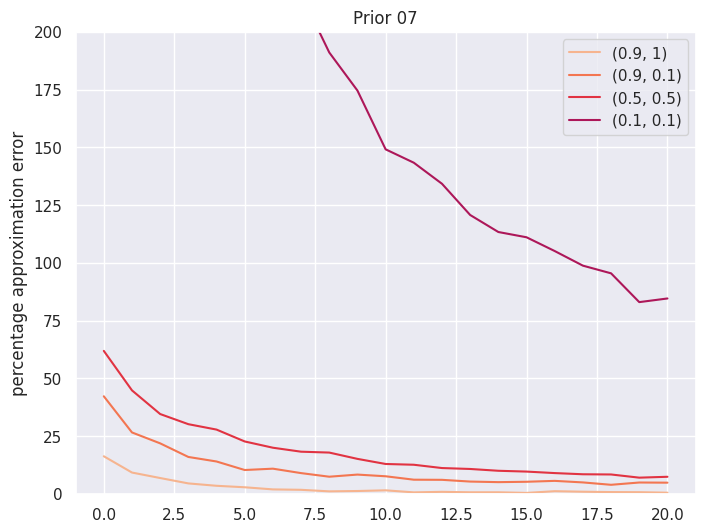

In [306]:
for j in range(len(env["real_params"])):
    plt.plot(np.round(perc_er_07[j], 2), label=str(env['real_params'][j]))

# Set the title, y-axis label, and y-axis limits for the plot
plt.title('Prior 07')
plt.ylabel('percentage approximation error')
plt.ylim(0, 200)

# Add a legend to the plot
plt.legend()


In [307]:
# List to store the percentage approximation error for each student profile for the pessimistic prior
perc_er_03 = percentage_approximation_error(env, students_mean_stats03, students_true_scores, 0.3)


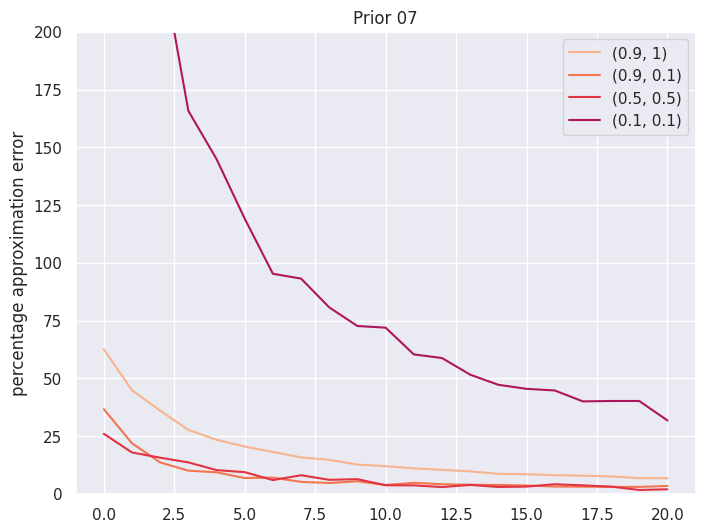

In [308]:
for j in range(len(env["real_params"])):
    plt.plot(np.round(perc_er_03[j], 2), label=str(env['real_params'][j]))

# Set the title, y-axis label, and y-axis limits for the plot
plt.title('Prior 07')
plt.ylabel('percentage approximation error')
plt.ylim(0, 200)

# Add a legend to the plot
plt.legend()


### Reults: Criteria Performance Analysis
##### Mean/KL Derivatives: Take the values of se, std, and error at the stopping time for each profile

In [309]:
def calculate_criteria(derivatives, stats, perc_er, dist):
    criteria_results = [[] for j in range(len(env["real_params"]))]

    for j in range(len(env["real_params"])):
        # Get the stopping index for the stats
        stop_index = int(derivatives[j][0])
        # Print for debugging
        if dist ==  True:
            stop_index += 1
        # Get the standard error (se) at the stopping index
        se = np.round(stats[j][2], 2)
        se_result = se[stop_index]

        # Get the standard deviation (std) at the stopping index
        std = np.round(stats[j][1], 2)
        std_result = std[stop_index]

        # Get the percentage approximation error at the stopping index
        perc_er_result = np.round(perc_er[j][stop_index],2)

        # Store the results for the metric
        criteria_results[j] = (stop_index, se_result, std_result, perc_er_result)
        profile_name = env["profile_names"][j]
        print(f"Profile: {profile_name}")
        print(criteria_results[j])
        print("\n")
    return criteria_results


##### Prior 03 & E1

In [310]:
print("Criteria Results for Mean Derivative: stopping item, se, std, perc_er")
dervsMean03E1 = calculate_criteria(student_changes_mean_of_mean03,students_mean_stats03, perc_er_03, False)


Criteria Results for Mean Derivative: stopping item, se, std, perc_er
Profile: Fluent
(11, 0.0, 0.31, 11.03)


Profile: Struggling Fluent
(7, 0.0, 0.35, 5.17)


Profile: Average
(8, 0.01, 0.4, 6.06)


Profile: Wheel-spinning
(8, 0.0, 0.23, 80.7)




In [311]:
print("Criteria Results for KL Derivative: stopping item, se, std, perc_er")
dervsDist03E1 = calculate_criteria(student_changes_mean_of_dist03,students_mean_stats03, perc_er_03, True)


Criteria Results for KL Derivative: stopping item, se, std, perc_er
Profile: Fluent
(16, 0.0, 0.31, 8.06)


Profile: Struggling Fluent
(10, 0.0, 0.35, 3.82)


Profile: Average
(12, 0.0, 0.42, 2.92)


Profile: Wheel-spinning
(15, 0.0, 0.22, 45.44)




### The same process as the code above is repeated for all combinations of priors and epsilons.


#### Prior 0.7 & E1

In [312]:
print("Criteria Results for Mean Derivative: stopping item, se, std, perc_er")
dervsMean07E1 = calculate_criteria(student_changes_mean_of_mean07,students_mean_stats07, perc_er_07, False)


Criteria Results for Mean Derivative: stopping item, se, std, perc_er
Profile: Fluent
(5, 0.0, 0.2, 2.83)


Profile: Struggling Fluent
(7, 0.0, 0.33, 8.96)


Profile: Average
(8, 0.01, 0.4, 17.85)


Profile: Wheel-spinning
(12, 0.0, 0.27, 134.21)




In [313]:
print("Criteria Results for KLD Derivative: stopping item, se, std, perc_er")
dervsDist07E1 = calculate_criteria(student_changes_mean_of_dist07,students_mean_stats07, perc_er_07, True)


Criteria Results for KLD Derivative: stopping item, se, std, perc_er
Profile: Fluent
(12, 0.0, 0.22, 0.85)


Profile: Struggling Fluent
(13, 0.0, 0.34, 5.3)


Profile: Average
(14, 0.0, 0.42, 9.97)


Profile: Wheel-spinning
(18, 0.0, 0.25, 95.44)




##### Prior 0.3 & E2

In [314]:
print("Criteria Results for Mean Derivative: stopping item, se, std, perc_er")
dervsMean03E2 = calculate_criteria(student_changes_mean_of_mean03_2,students_mean_stats03, perc_er_03, False)


Criteria Results for Mean Derivative: stopping item, se, std, perc_er
Profile: Fluent
(9, 0.0, 0.32, 12.65)


Profile: Struggling Fluent
(4, 0.01, 0.35, 9.3)


Profile: Average
(3, 0.01, 0.36, 13.6)


Profile: Wheel-spinning
(5, 0.0, 0.25, 119.12)




In [315]:
print("Criteria Results for KLD Derivative: stopping item, se, std, perc_er")
dervsDist03E2 = calculate_criteria(student_changes_mean_of_dist03_2,students_mean_stats03, perc_er_03, True)


Criteria Results for KLD Derivative: stopping item, se, std, perc_er
Profile: Fluent
(3, 0.01, 0.35, 27.67)


Profile: Struggling Fluent
(9, 0.0, 0.35, 5.42)


Profile: Average
(7, 0.01, 0.39, 8.04)


Profile: Wheel-spinning
(12, 0.0, 0.22, 58.77)




##### Prior 0.7 & E2

In [316]:
print("Criteria Results for Mean Derivative: stopping item, se, std, perc_er")
dervsMean07E2 = calculate_criteria(student_changes_mean_of_mean07e2,students_mean_stats07, perc_er_07, False)


Criteria Results for Mean Derivative: stopping item, se, std, perc_er
Profile: Fluent
(4, 0.0, 0.19, 3.47)


Profile: Struggling Fluent
(5, 0.0, 0.32, 10.3)


Profile: Average
(4, 0.01, 0.36, 27.8)


Profile: Wheel-spinning
(7, 0.0, 0.3, 216.32)




In [317]:
print("Criteria Results for KLD Derivative: stopping item, se, std, perc_er")
dervsDist07E2 = calculate_criteria(student_changes_mean_of_dist07e2,students_mean_stats07, perc_er_07, True)


Criteria Results for KLD Derivative: stopping item, se, std, perc_er
Profile: Fluent
(11, 0.0, 0.21, 0.62)


Profile: Struggling Fluent
(11, 0.0, 0.34, 6.11)


Profile: Average
(11, 0.0, 0.41, 12.58)


Profile: Wheel-spinning
(14, 0.0, 0.26, 113.33)




# 👏 The End 👏 